<a href="https://colab.research.google.com/github/MedDataInt/Drug-discovery-from-TorchDrug/blob/main/TorchDrug_Retrosynthesis_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

Retrosynthesis is a fundamental task in drug discovery. Given a target molecule, the goal of retrosynthesis is to identify a set of reactants that can produce the target.

In this example, we will show how to predict retrosynthesis using G2Gs framework. G2Gs first identifies the reaction centers, i.e., bonds generated in the product. Based on the reaction centers, the product is broken into several synthons and each synthon is translated to a reactant.

### Manual Steps

1.   Get your own copy of this file via "File > Save a copy in Drive...",
2.   Set the runtime to **GPU** via "Runtime > Change runtime type..."

### Colab Tutorials

#### Quick Start
1. [Basic Usage and Pipeline](https://colab.research.google.com/drive/1Tbnr1Fog_YjkqU1MOhcVLuxqZ4DC-c8-#forceEdit=true&sandboxMode=true)

#### Drug Discovery Tasks
1. [Property Prediction](https://colab.research.google.com/drive/1sb2w3evdEWm-GYo28RksvzJ74p63xHMn?usp=sharing#forceEdit=true&sandboxMode=true)
2. [Pretrained Molecular Representations](https://colab.research.google.com/drive/10faCIVIfln20f2h1oQk2UrXiAMqZKLoW?usp=sharing#forceEdit=true&sandboxMode=true)
3. [De Novo Molecule Design](https://colab.research.google.com/drive/1JEMiMvSBuqCuzzREYpviNZZRVOYsgivA?usp=sharing#forceEdit=true&sandboxMode=true)
4. [Retrosynthesis](https://colab.research.google.com/drive/1IH1hk7K3MaxAEe5m6CFY7Eyej3RuiEL1?usp=sharing#forceEdit=true&sandboxMode=true)
5. [Knowledge Graph Reasoning](https://colab.research.google.com/drive/1-sjqQZhYrGM0HiMuaqXOiqhDNlJi7g_I?usp=sharing#forceEdit=true&sandboxMode=true)

In [ ]:
import os
import torch
os.environ["TORCH_VERSION"] = torch.__version__

!pip install torch-scatter torch-cluster -f https://pytorch-geometric.com/whl/torch-$TORCH_VERSION.html
!pip install torchdrug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 29.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 200 kB 17.8 MB/s 
     |████████████████████████████████| 108 kB 65.1 MB/s 
     |████████████████████████████████| 36.8 MB 1.2 MB/s 


# Prepare the Dataset (~8 min)
We use the standard USPTO50k dataset. This dataset contains 50k molecules and their synthesis pathways.

First, let’s download and load the dataset. This may take a while.

There are two modes to load the dataset. The reaction mode loads the dataset as (reactants, product) pairs, which is used for center identification. The synthon mode loads the dataset as (reactant, synthon) pairs, which is used for synthon completion.


In [ ]:
from torchdrug import datasets, data

reaction_dataset = datasets.USPTO50k("~/molecule-datasets/",
                                     node_feature="center_identification",
                                     kekulize=True)
synthon_dataset = datasets.USPTO50k("~/molecule-datasets/", as_synthon=True,
                                    node_feature="synthon_completion",
                                    kekulize=True)

05:28:51   Downloading https://raw.githubusercontent.com/connorcoley/retrosim/master/retrosim/data/data_processed.csv to /root/molecule-datasets/data_processed.csv


Loading /root/molecule-datasets/data_processed.csv: 100%|██████████| 50017/50017 [00:00<00:00, 72505.54it/s]
Constructing molecules from SMILES:   0%|          | 0/50016 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/utils/decorator.py:112: UserWarning: from_molecule(): argument `node_feature` is deprecated in favor of `atom_feature`
  warnings.warn("%s(): argument `%s` is deprecated in favor of `%s`" % (func.__name__, key, value))
Computing reaction centers:   0%|          | 0/50016 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/graph.py:542: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  scale = scale[-1] // scale
Comp

Then we visualize some samples from the dataset. For the reaction dataset, we can split reactant and product graphs into individual molecules using connected_components(). Note USPTO50k ignores all non-target products, so there is only one product on the right hand side.



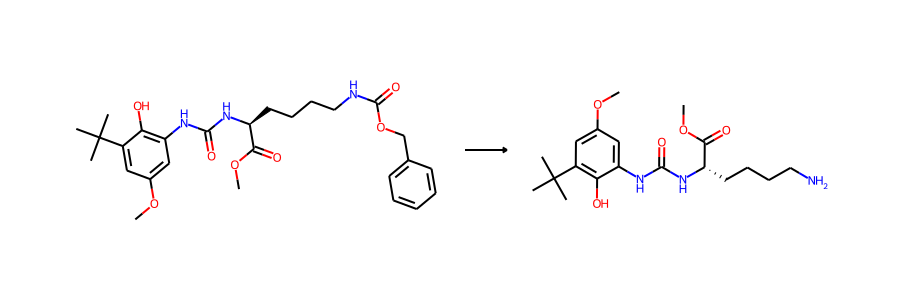

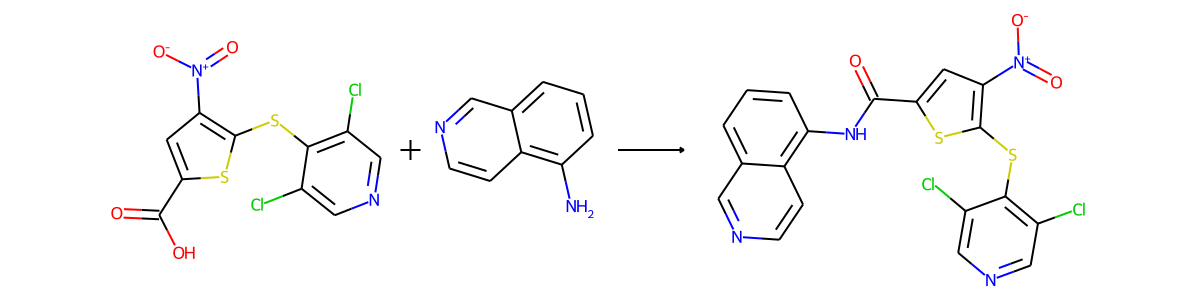

In [ ]:
from IPython.display import display, Image
import torch
from torchdrug.utils import plot

for i in range(2):
    sample = reaction_dataset[i]
    reactant, product = sample["graph"]
    reactants = reactant.connected_components()[0]
    products = product.connected_components()[0]
    save_file = "reaction_%d.png" % i
    plot.reaction(reactants, products, save_file=save_file)
    display(Image(filename=save_file, height=150))

Here are the corresponding samples in the synthon dataset.



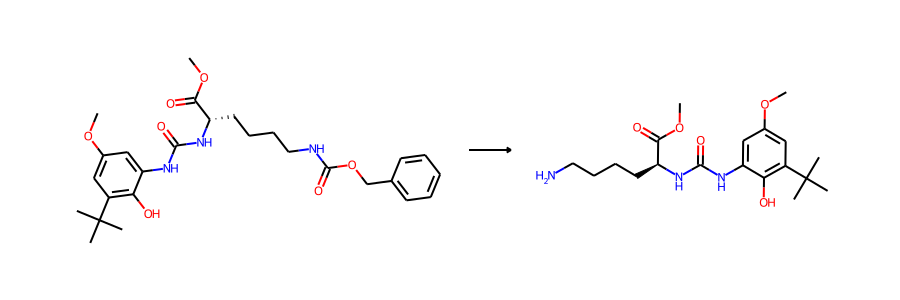

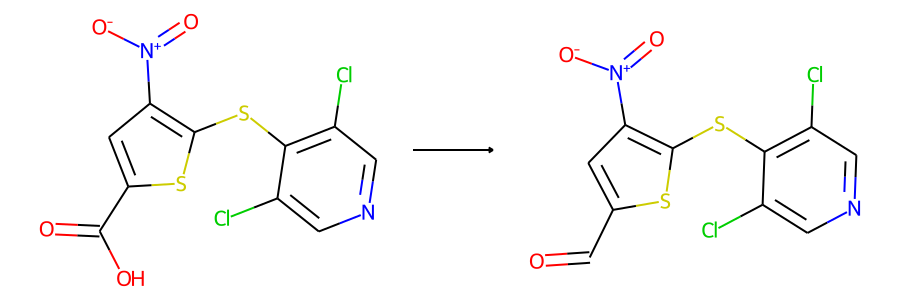

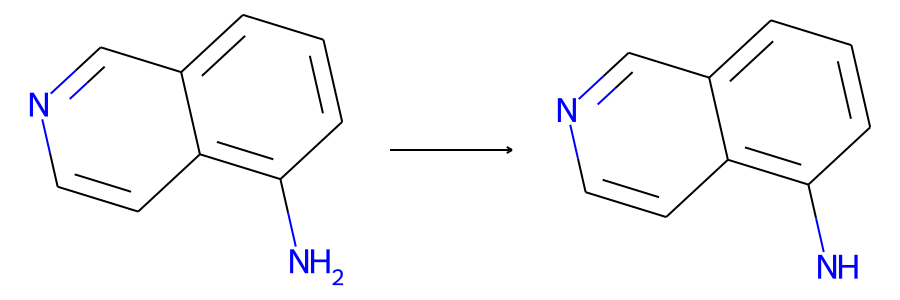

In [ ]:
for i in range(3):
    sample = synthon_dataset[i]
    reactant, synthon = sample["graph"]
    save_file = "synthon_%d.png" % i
    plot.reaction([reactant], [synthon], save_file=save_file)
    display(Image(filename=save_file, height=150))

To ensure the same split is used by both datasets, we can set the random seed before calling split().



In [ ]:
torch.manual_seed(1)
reaction_train, reaction_valid, reaction_test = reaction_dataset.split()
torch.manual_seed(1)
synthon_train, synthon_valid, synthon_test = synthon_dataset.split()

# Center Identification

Now we define our model. We use a Relational Graph Convolutional Network (RGCN) as our representation model, and wrap it for the center identification task. Note other graph representation learning models can also be used here.


In [ ]:
from torchdrug import core, models, tasks

reaction_model = models.RGCN(input_dim=reaction_dataset.node_feature_dim,
                    hidden_dims=[256, 256, 256, 256, 256, 256],
                    num_relation=reaction_dataset.num_bond_type,
                    concat_hidden=True)
reaction_task = tasks.CenterIdentification(reaction_model,
                                           feature=("graph", "atom", "bond"))

In [ ]:
reaction_optimizer = torch.optim.Adam(reaction_task.parameters(), lr=1e-3)
reaction_solver = core.Engine(reaction_task, reaction_train, reaction_valid,
                              reaction_test, reaction_optimizer,
                              gpus=[0], batch_size=128)
reaction_solver.train(num_epoch=10)
reaction_solver.evaluate("valid")
reaction_solver.save("g2gs_reaction_model.pth")

16:52:14   Preprocess training set


We can show some predictions from our model. For diversity, we collect samples from 4 different reaction types.



In [ ]:
from torchdrug import utils

batch = []
reaction_set = set()
for sample in reaction_valid:
    if sample["reaction"] not in reaction_set:
        reaction_set.add(sample["reaction"])
        batch.append(sample)
        if len(batch) == 4:
            break
batch = data.graph_collate(batch)
batch = utils.cuda(batch)
result = reaction_task.predict_synthon(batch)

The following code visualizes the ground truths as well as our predictions on the samples. We use blue for ground truths, red for wrong predictions, and purple for correct predictions.



In [ ]:
def atoms_and_bonds(molecule, reaction_center):
    is_reaction_atom = (molecule.atom_map > 0) & \
                       (molecule.atom_map.unsqueeze(-1) == \
                        reaction_center.unsqueeze(0)).any(dim=-1)
    node_in, node_out = molecule.edge_list.t()[:2]
    edge_map = molecule.atom_map[molecule.edge_list[:, :2]]
    is_reaction_bond = (edge_map > 0).all(dim=-1) & \
                       (edge_map == reaction_center.unsqueeze(0)).all(dim=-1)
    atoms = is_reaction_atom.nonzero().flatten().tolist()
    bonds = is_reaction_bond[node_in < node_out].nonzero().flatten().tolist()
    return atoms, bonds

products = batch["graph"][1]
reaction_centers = result["reaction_center"]

for i, product in enumerate(products):
    true_atoms, true_bonds = atoms_and_bonds(product, product.reaction_center)
    true_atoms, true_bonds = set(true_atoms), set(true_bonds)
    pred_atoms, pred_bonds = atoms_and_bonds(product, reaction_centers[i])
    pred_atoms, pred_bonds = set(pred_atoms), set(pred_bonds)
    overlap_atoms = true_atoms.intersection(pred_atoms)
    overlap_bonds = true_bonds.intersection(pred_bonds)
    atoms = true_atoms.union(pred_atoms)
    bonds = true_bonds.union(pred_bonds)

    red = (1, 0.5, 0.5)
    blue = (0.5, 0.5, 1)
    purple = (1, 0.5, 1)
    atom_colors = {}
    bond_colors = {}
    for atom in atoms:
        if atom in overlap_atoms:
            atom_colors[atom] = purple
        elif atom in pred_atoms:
            atom_colors[atom] = red
        else:
            atom_colors[atom] = blue
    for bond in bonds:
        if bond in overlap_bonds:
            bond_colors[bond] = purple
        elif bond in pred_bonds:
            bond_colors[bond] = red
        else:
            bond_colors[bond] = blue

    save_file = "center_prediction_%d.png" % i
    plot.highlight(product, atoms, bonds, atom_colors, bond_colors,
                   save_file=save_file)
    display(Image(filename=save_file, height=150))

# Synthon Completion
Similarly, we train a synthon completion model on the synthon dataset.



In [ ]:
synthon_model = models.RGCN(input_dim=synthon_dataset.node_feature_dim,
                            hidden_dims=[256, 256, 256, 256, 256, 256],
                            num_relation=synthon_dataset.num_bond_type,
                            concat_hidden=True)
synthon_task = tasks.SynthonCompletion(synthon_model, feature=("graph",))

synthon_optimizer = torch.optim.Adam(synthon_task.parameters(), lr=1e-3)
synthon_solver = core.Engine(synthon_task, synthon_train, synthon_valid,
                             synthon_test, synthon_optimizer,
                             gpus=[0], batch_size=128)
synthon_solver.train(num_epoch=1)
synthon_solver.evaluate("valid")
synthon_solver.save("g2gs_synthon_model.pth")

We then perform beam search to generate reactant candidates.



In [ ]:
%matplotlib inline

batch = []
reaction_set = set()
for sample in synthon_valid:
    if sample["reaction"] not in reaction_set:
        reaction_set.add(sample["reaction"])
        batch.append(sample)
        if len(batch) == 4:
            break
batch = data.graph_collate(batch)
batch = utils.cuda(batch)
reactants, synthons = batch["graph"]
reactants = reactants.ion_to_molecule()
predictions = synthon_task.predict_reactant(batch, num_beam=10, max_prediction=5)

synthon_id = -1
i = 0
titles = []
graphs = []
for prediction in predictions:
    if synthon_id != prediction.synthon_id:
        synthon_id = prediction.synthon_id.item()
        i = 0
        graphs.append(reactants[synthon_id])
        titles.append("Truth %d" % synthon_id)
    i += 1
    graphs.append(prediction)
    if reactants[synthon_id] == prediction:
        titles.append("Prediction %d-%d, Correct!" % (synthon_id, i))
    else:
        titles.append("Prediction %d-%d" % (synthon_id, i))

# reset attributes so that pack can work properly
mols = [graph.to_molecule() for graph in graphs]
graphs = data.PackedMolecule.from_molecule(mols)
graphs.visualize(titles, save_file="uspto50k_synthon_valid.png", num_col=6)

For each row in the visualization, the first molecule corresponds to the ground truth. The rest molecules are candidates from beam search, ordered by their log likelihood. We can see that our model can recall ground truth in top-5 predictions for most samples.



# Retrosynthesis

Given the trained models, we can combine them into an end2end pipeline for retrosynthesis. This is done by wrapping the two sub tasks with a retrosynthesis task.

The pipeline will perform beam search over all possible combinations between the predictions from two sub tasks. For demonstration, we use a small beam size and only evaluate on a subset of the validation set. Note the results will be better if we give more budget to the beam search.

In [ ]:
from torch.utils import data as torch_data

lengths = [len(reaction_valid) // 10,
           len(reaction_valid) - len(reaction_valid) // 10]
reaction_valid_small = torch_data.random_split(reaction_valid, lengths)[0]

reaction_task.preprocess(reaction_train, None, None)
synthon_task.preprocess(synthon_train, None, None)
task = tasks.Retrosynthesis(reaction_task, synthon_task, center_topk=2, num_synthon_beam=5,
                            max_prediction=10)
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, reaction_train, reaction_valid_small, reaction_test,
                     optimizer, gpus=[0], batch_size=32)

To load parameters two sub tasks, we just load each checkpoint. Note load_optimizer should be set to False to avoid conflicts.



In [ ]:
solver.load("g2gs_reaction_model.pth", load_optimizer=False)
solver.load("g2gs_synthon_model.pth", load_optimizer=False)
solver.evaluate("valid")

Here are the top-1 predictions for samples in the validation set.



In [ ]:
batch = []
reaction_set = set()
for sample in reaction_valid:
    if sample["reaction"] not in reaction_set:
        reaction_set.add(sample["reaction"])
        batch.append(sample)
        if len(batch) == 4:
            break
batch = data.graph_collate(batch)
batch = utils.cuda(batch)
predictions, num_prediction = task.predict(batch)

products = batch["graph"][1]
top1_index = num_prediction.cumsum(0) - num_prediction
for i in range(len(products)):
    reactant = predictions[top1_index[i]].connected_components()[0]
    product = products[i].connected_components()[0]
    save_file = "reaction_prediction_%d.png" % i
    plot.reaction(reactant, product, save_file=save_file)
    display(Image(filename=save_file, height=150))